# 4 Cell trajectory analysis

4.1 Tracking of single cells using DeepCell-Tracking
4.2 Trajectory measures Mean Squared Displacment (MSD) and Persistency

In [3]:
import numpy as np
import imageio.v2 as iio
import os
import pandas as pd

In [4]:
# Define main path
path = '/Users/olyssa/Desktop/BA_data'

## 4.1 Tracking of single cells using DeepCell-Tracking

In [ ]:
os.environ["DEEPCELL_ACCESS_TOKEN"] = "" # enter valid access token
from deepcell.applications import CellTracking
import tensorflow as tf

In [ ]:
# Enable usage of GPU
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized
    pass

# Define cell tracker
tracker = CellTracking()

In [ ]:
e = 1
knockdown_nr = '005023'

stack = iio.imread(path + f'/img_stacks_cut/exp{e}_imgs_cut/{knockdown_nr}_hyperstack_drift_corrected_cyto_MIST_cut.tif')
stack = np.expand_dims(stack, axis=3)

mask_stack = iio.imread(path + f'masks_drift_corrected/exp{e}_masks/masks_stack_{knockdown_nr}_exp{e}_cyto_cut.tif')
mask_stack = np.expand_dims(mask_stack, axis=3)

# Computation of tracks
tracked_data = tracker.track(stack, mask_stack)

y_tracked = tracked_data['y_tracked']
np.save(path+f'cells_tracked/tracked_cyto/{knockdown_nr}_exp{e}_tracked_cyto.npy', y_tracked)

## 4.2 Trajectory measures Mean Squared Displacment (MSD) and Persistency

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from tracking import create_whole_tracks, plot_cell_movements, create_data_list
import numpy as np

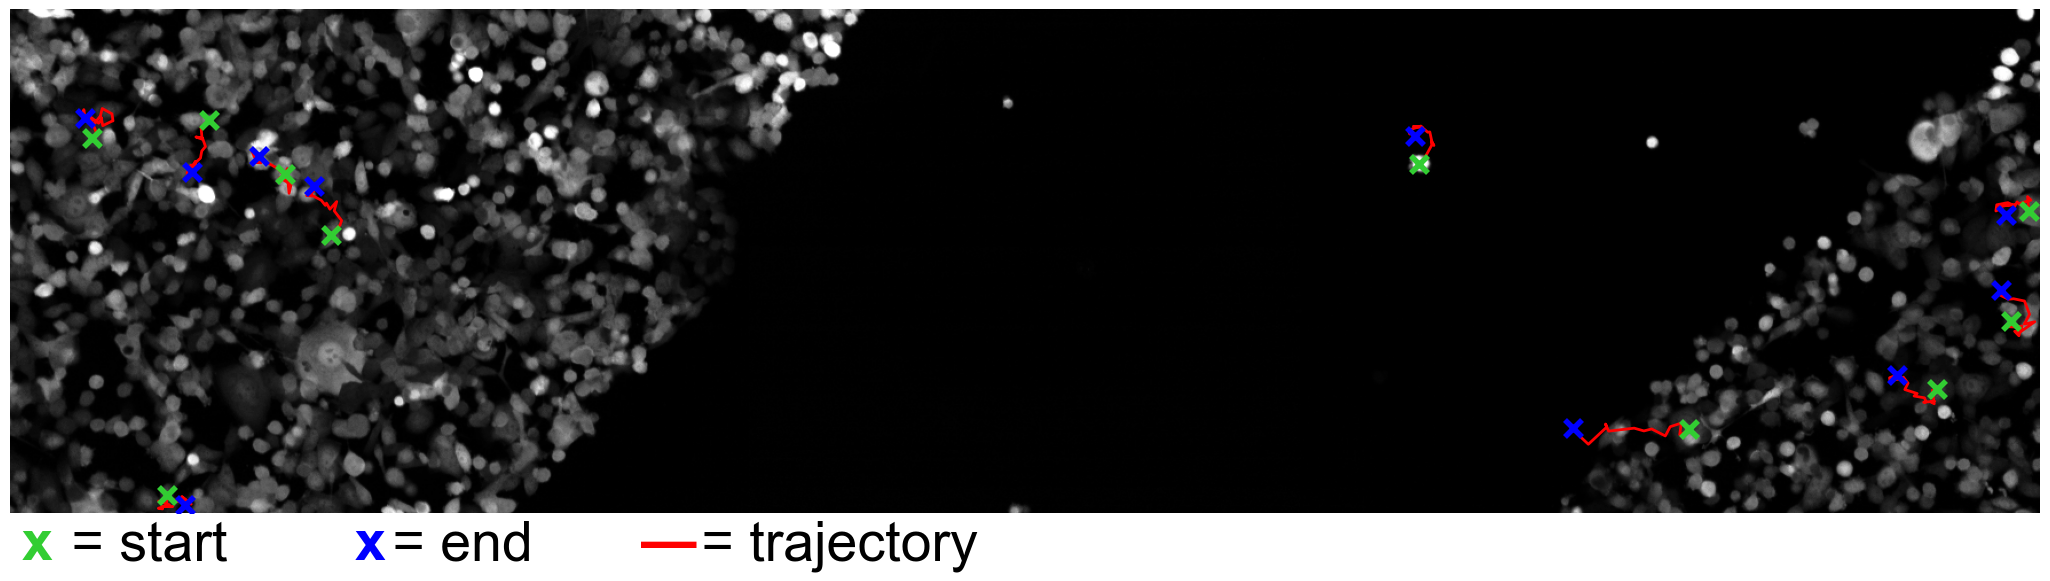

In [6]:
# Plot cell movements: t=0 (green), t=17 (blue)
knockdown_nr = '005023'
e = 1

y_tracked = np.load(path+f'/{knockdown_nr}_exp{e}_tracked_cyto.npy',
                    allow_pickle=True)
df_merged, df = create_whole_tracks(y_tracked)
stack = iio.imread(path + f'/img_stacks_cut/exp{e}_imgs_cut/{knockdown_nr}_hyperstack_drift_corrected_cyto_MIST_cut.tif')
plot_cell_movements(df_merged, stack)

In [7]:
# Create list data
list_data = create_data_list(df_merged)

data = []
for track in range(len(list_data)):
    data.append(list_data[track])

### 4.2.1 Mean Squared Displacement (MSD)

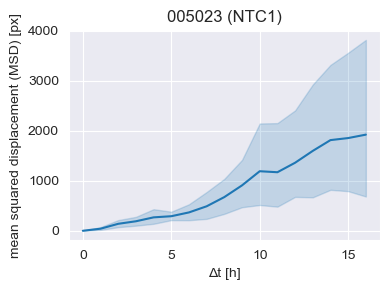

In [24]:
# Calculate MSD
def calculate_MSD(list_data):
    df_diff_sq = pd.DataFrame()
    list_diff_sq = []
    time_MSD = []
    for c in range(len(list_data)):
        r_list = []
        for t in range(0, 17):
            r = np.sqrt((list_data[c][1][t]-list_data[c][1][0])**2 + (list_data[c][2][t]-list_data[c][2][0])**2)
            r_list.append(r)
        diff_sq = np.array(r_list)**2
        df_diff_sq[f'diff_sq{c}'] = diff_sq
        list_diff_sq = np.concatenate((list_diff_sq, diff_sq))
        time_MSD = np.concatenate((time_MSD, list(range(17))))

    return time_MSD, list_diff_sq

# Calculate MSD
time_MSD, list_diff_sq = calculate_MSD(data)

# Plot MSD
fig, ax = plt.subplots(figsize=(4, 3))
sns.lineplot(x=time_MSD, y=list_diff_sq, errorbar=('ci', 95))
plt.title(f'005023 (NTC1)')
plt.xlabel('Δt [h]')
plt.ylabel('mean squared displacement (MSD) [px]')
plt.tight_layout()
plt.show()

### 4.2.2 Persistence (P)

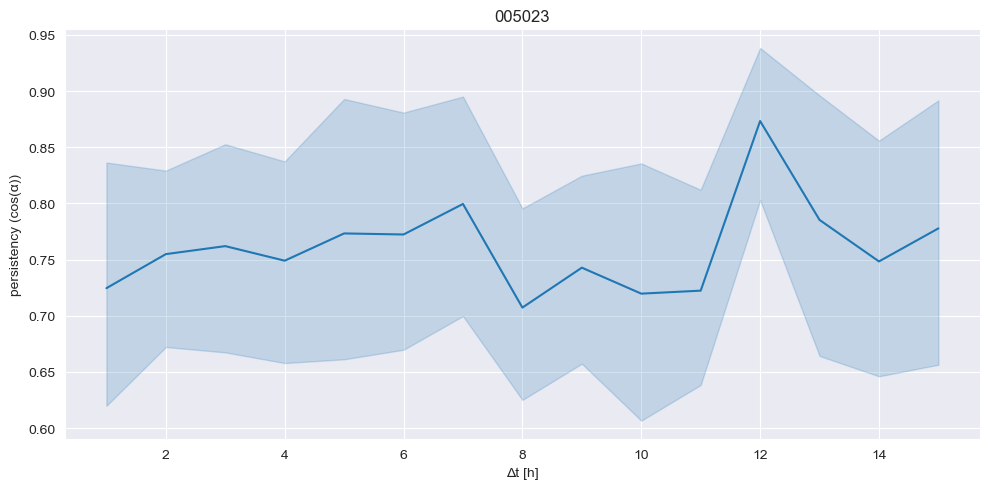

In [20]:
def calculate_persistence(list_data):
    list_persistence = []
    time_p = []
    for c in range(len(list_data)):
        p_list = []
        for t in range(17-2):
            vec_1 = [list_data[c][1][t+1]-list_data[c][1][t], list_data[c][2][t+1]-list_data[c][2][t]]
            vec_2 = [list_data[c][1][t+2]-list_data[c][1][t+1], list_data[c][2][t+2]-list_data[c][2][t+1]]
            p = np.cos(np.dot(vec_1, vec_2)/(np.linalg.norm(vec_1)*np.linalg.norm(vec_2)))
            p_list.append(p)
        list_persistence = np.concatenate((list_persistence, p_list))
        time_p = np.concatenate((time_p, list(range(1, 16))))

    return time_p, list_persistence

# Calculate P
time_p_myh9, list_persistence_myh9 = calculate_persistence(data)

# Plot P 
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=time_p_myh9, y=list_persistence_myh9, errorbar=('ci', 95))
plt.title(f'005023 (NTC1)')
plt.ylabel('Persistency (cos(α))')
plt.xlabel('Δt [h]')
plt.tight_layout()
plt.show()